TF Tutorial: https://www.tensorflow.org/tutorials/keras/regression

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [50]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.0


*** Parameters

In [51]:
#################################################################
sensor = 3
#################################################################

Read and organize data

In [52]:
sensors = ['98F4AB39DB50', '98F4AB38C884', '4C11AEE82D80']
columns = ['CO2', 'VOC', 'RH', 'TEM', 'PM25', 'TIME', 'SCORE']

csv = f"../{sensors[sensor -1]}-processed.csv"

In [53]:
raw_dataset = pd.read_csv(csv)
dataset = raw_dataset.copy()
dataset = dataset.drop('TIME', axis=1)

In [54]:
dataset.isna().sum()
dataset = dataset.dropna()

In [55]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Inspect data

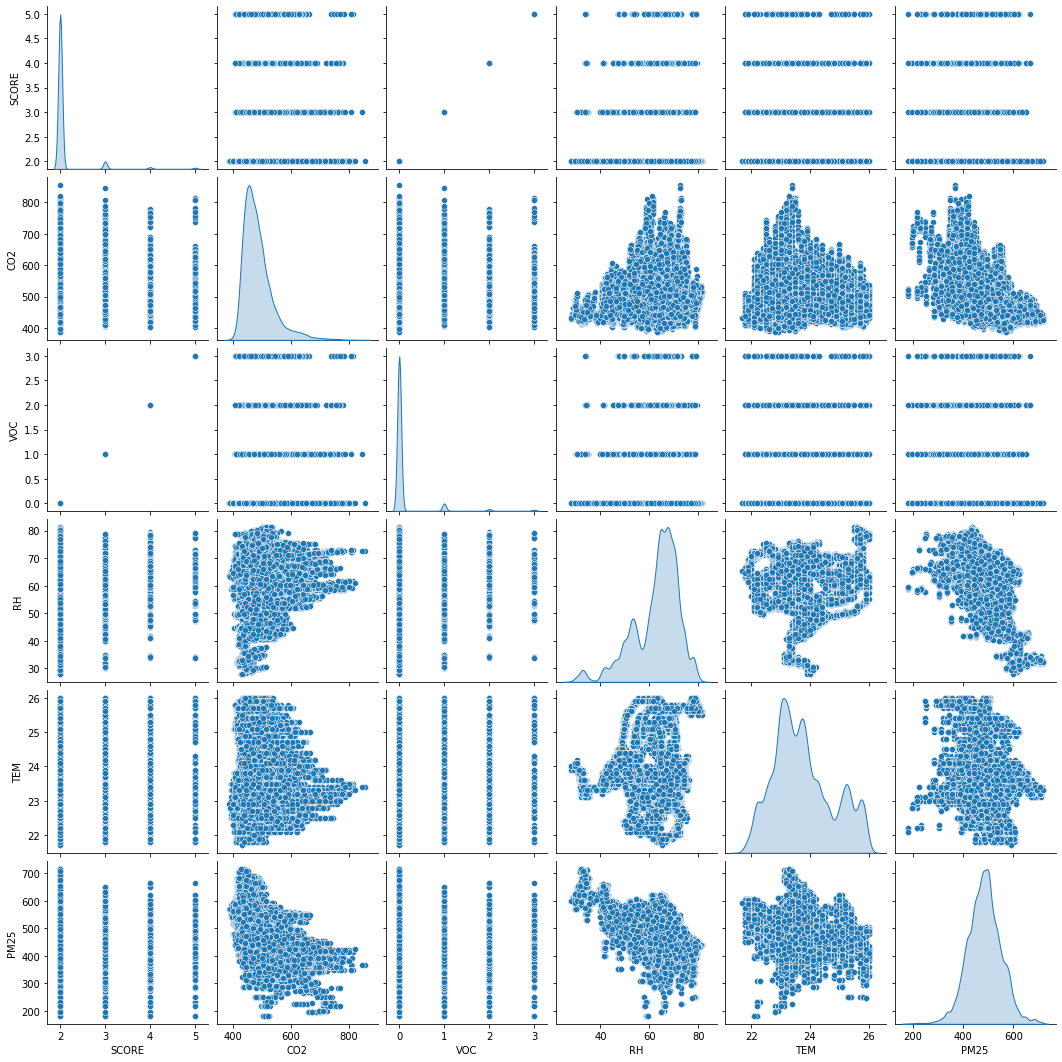

In [56]:
sns.pairplot(train_dataset[['SCORE', 'CO2', 'VOC', 'RH', 'TEM', 'PM25']], diag_kind='kde')


In [57]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CO2,55901.0,485.626143,53.016574,386.0,450.0,474.0,506.0,856.0
VOC,55901.0,0.088710,0.381436,0.0,0.0,0.0,0.0,3.0
RH,55901.0,62.800860,9.314716,27.8,58.1,64.8,69.2,81.4
TEM,55901.0,23.760001,1.005883,21.7,23.0,23.6,24.4,26.0
PM25,55901.0,484.588379,66.461416,180.0,443.0,485.0,526.0,717.0
SCORE,55901.0,2.088710,0.381436,2.0,2.0,2.0,2.0,5.0


In [58]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('SCORE')
test_labels = test_features.pop('SCORE')

Normalization

In [59]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
CO2,485.626143,53.016574
VOC,0.088710,0.381436
RH,62.800860,9.314716
TEM,23.760001,1.005883
PM25,484.588379,66.461416
SCORE,2.088710,0.381436


In [60]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[485.626   0.089  62.801  23.76  484.588]]


In [61]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[475.    0.   72.4  23.2 397. ]]

Normalized: [[-0.2  -0.23  1.03 -0.56 -1.32]]


Linear regression with one variable

In [62]:
co2 = np.array(train_features['CO2'])

co2_normalizer = layers.Normalization(input_shape=[1,], axis=None)
co2_normalizer.adapt(co2)

In [63]:
co2_model = tf.keras.Sequential([
    co2_normalizer,
    layers.Dense(units=1)
])

co2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_8 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [64]:
co2_model.predict(co2[:10])

array([[ 0.076],
       [ 0.047],
       [-0.389],
       [-0.432],
       [ 0.277],
       [ 0.055],
       [ 0.026],
       [-0.074],
       [-0.017],
       [-0.132]], dtype=float32)

In [65]:
co2_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [66]:
%%time
history = co2_model.fit(
    train_features['CO2'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 2min 43s
Wall time: 1min 57s


In [67]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,0.101922,0.092611,95
96,0.102513,0.090381,96
97,0.100994,0.101538,97
98,0.102181,0.095724,98
99,0.101045,0.093645,99


In [68]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 0.2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [SCORE]')
  plt.legend()
  plt.grid(True)

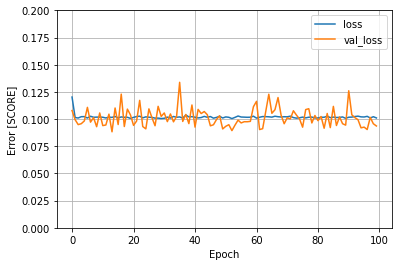

In [69]:
plot_loss(history)

In [70]:
test_results = {}

test_results['co2_model'] = co2_model.evaluate(
    test_features['CO2'],
    test_labels, verbose=0)

In [71]:
x = tf.linspace(0.0, 250, 251)
y = co2_model.predict(x)

In [72]:
def plot_co2(x, y):
  plt.scatter(train_features['CO2'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('CO2')
  plt.ylabel('SCORE')
  plt.legend()

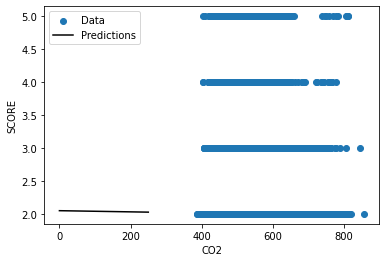

In [73]:
plot_co2(x, y)

Linear regression with multiple inputs

In [74]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [75]:
linear_model.predict(train_features[:10])

array([[-1.788],
       [ 0.19 ],
       [-0.393],
       [-1.213],
       [-0.587],
       [-1.479],
       [-1.488],
       [-2.024],
       [-1.975],
       [-1.131]], dtype=float32)

In [76]:
linear_model.layers[1].kernel

<tf.Variable 'dense_9/kernel:0' shape=(5, 1) dtype=float32, numpy=
array([[ 0.577],
       [ 0.007],
       [-0.5  ],
       [-0.131],
       [ 0.932]], dtype=float32)>

In [77]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [78]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

CPU times: total: 2min 52s
Wall time: 2min


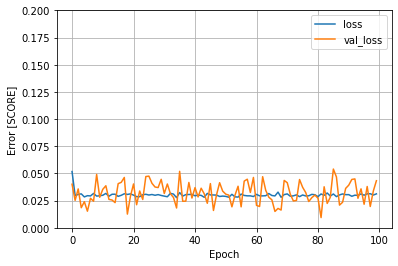

In [79]:
plot_loss(history)

In [80]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

Regression with a deep neural network (DNN)

In [81]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

Regression using a DNN and a single input

In [82]:
dnn_co2_model = build_and_compile_model(co2_normalizer)
dnn_co2_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_10 (Dense)            (None, 64)                128       
                                                                 
 dense_11 (Dense)            (None, 64)                4160      
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [83]:
%%time
history = dnn_co2_model.fit(
    train_features['CO2'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 4min 8s
Wall time: 2min 18s


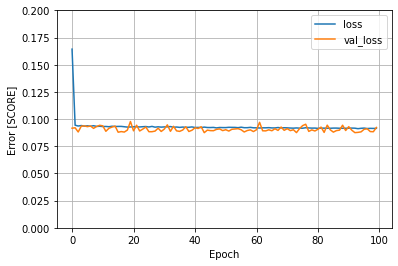

In [84]:
plot_loss(history)

In [85]:
x = tf.linspace(0.0, 250, 251)
y = dnn_co2_model.predict(x)

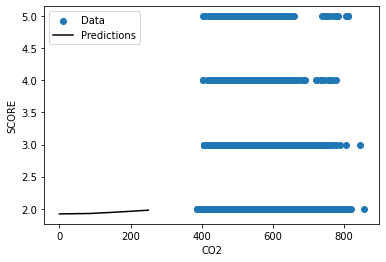

In [86]:
plot_co2(x, y)

In [87]:
test_results['dnn_co2_model'] = dnn_co2_model.evaluate(
    test_features['CO2'], test_labels,
    verbose=0)

Regression using a DNN and multiple inputs

In [88]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 5)                11        
 ion)                                                            
                                                                 
 dense_13 (Dense)            (None, 64)                384       
                                                                 
 dense_14 (Dense)            (None, 64)                4160      
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,620
Trainable params: 4,609
Non-trainable params: 11
_________________________________________________________________


In [89]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: total: 4min 21s
Wall time: 2min 20s


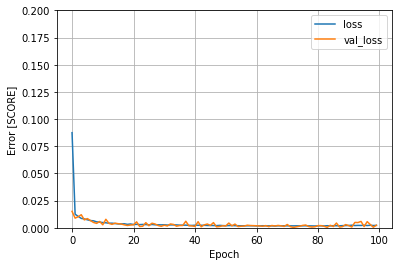

In [90]:
plot_loss(history)

In [91]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

Performance

In [92]:
pd.DataFrame(test_results, index=['Mean absolute error [SCORE]']).T

,Mean absolute error [SCORE]
co2_model,0.098401
linear_model,0.042924
dnn_co2_model,0.097103
dnn_model,0.002417


Predictions

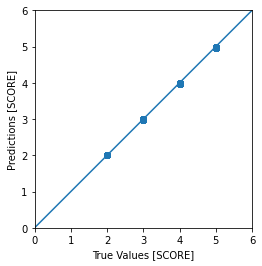

In [93]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [SCORE]')
plt.ylabel('Predictions [SCORE]')
lims = [0, 6]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

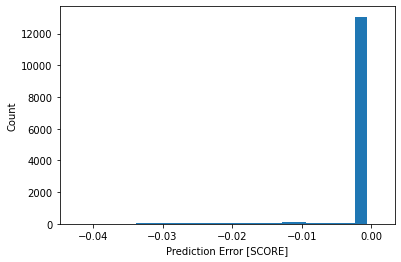

In [94]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [SCORE]')
_ = plt.ylabel('Count')

In [95]:
dnn_model.save(f'dnn_model_sensor_{sensor}')

INFO:tensorflow:Assets written to: dnn_model_sensor_3\assets


*** RELOAD MODEL

In [100]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [101]:
print(test_results)
# print(test_results["reloaded"])

{'co2_model': 0.09840072691440582, 'linear_model': 0.042923517525196075, 'dnn_co2_model': 0.09710312634706497, 'dnn_model': 0.0024174023419618607, 'reloaded': 1.9957815408706665}


In [97]:
pd.DataFrame(test_results, index=['Mean absolute error [SCORE]']).T

,Mean absolute error [SCORE]
co2_model,0.098401
linear_model,0.042924
dnn_co2_model,0.097103
dnn_model,0.002417
reloaded,1.995782
